Data from head and neck cancer patients, sourced from The Cancer Imaging Archive. 
This dataset contains survival time, event indicators, and covariates such as age, treatment type, and tumor stage

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install openpyxl
# %pip install openpyxl  # got it working!



### 1. Kaplan-Meier Analysis
- Generate Kaplan-Meier survival curves for at least two distinct groups (e.g., treatment
type, age group, or tumor stage), ensuring each group has its own plot.
-  For each plot, conduct a log-rank test to compare survival differences between the
groups.


int64


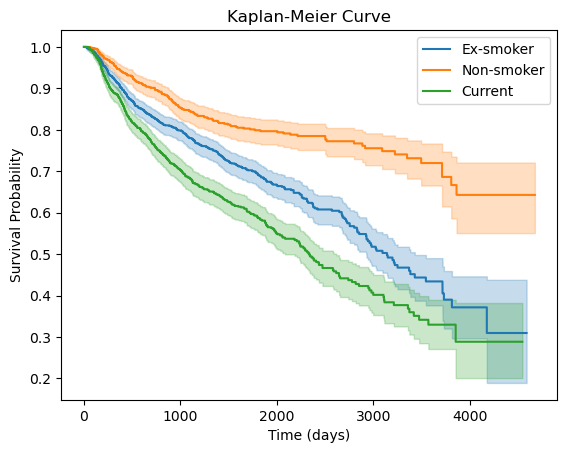

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         128.17 <0.005     92.46

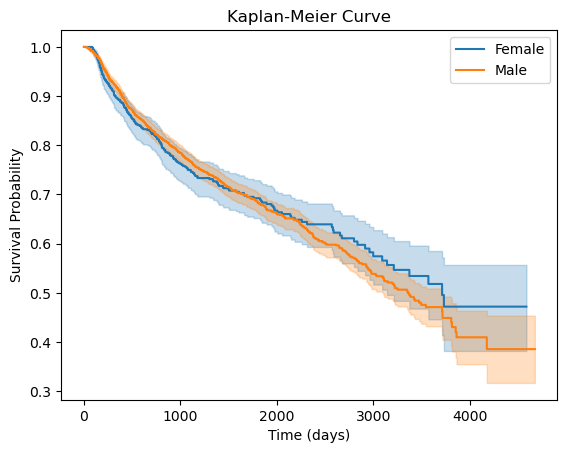

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.41

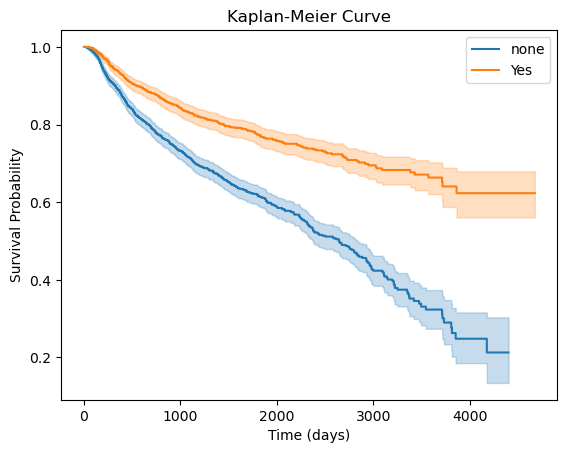

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         124.19 <0.005     93.40

In [131]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

# Load the dataset
data1 = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx', engine='openpyxl')
data=data1.copy()

#OneHot enconding of status? --> doesnt change anything 
data["Status"] = np.where(data["Status"]=="Dead", 1, 0)
# adjust time 
data['time'] = (data['Last FU'] - data['RT Start']).dt.days
print(data['time'].dtype)

# Fit the Kaplan-Meier estimator
# INSTANTIATE, FIT, PREDICT
kmf = KaplanMeierFitter()

smoker_data = data[data['Smoking Status'] != 'unknown']
for group in smoker_data['Smoking Status'].unique():
    mask = smoker_data['Smoking Status'] == group # rows where Smoking Status == group being examined
    kmf.fit(smoker_data[mask]['time'], event_observed=smoker_data[mask]['Status'], label=str(group))
    kmf.plot_survival_function() #intuitive and lots of built in funxality, .print_saummary() 
# if we want to stratify by a particular feature, just fit 2 separate objects 
# 'starify' == looking at survival as function of this variable 

# Plot the Kaplan-Meier curve
plt.title('Kaplan-Meier Curve')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()
# log rank test, multilpe variables:
results = multivariate_logrank_test(
    event_durations=smoker_data['time'],
    event_observed=smoker_data['Status'],
    groups=smoker_data['Smoking Status']
)
results.print_summary()




for group in data['Sex'].unique():
    mask = data['Sex'] == group # rows where Sex == group being examined
    kmf.fit(data[mask]['time'], event_observed=data[mask]['Status'], label=str(group))
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()

# log rank test, 2 variables:
Males = data['Sex'] == 'Male'
Females = data['Sex'] == 'Female'
results = logrank_test(
    data[Males]['time'], data[Females]['time'],
    event_observed_A=data[Males]['Status'],
    event_observed_B=data[Females]['Status']
)

results.print_summary()




for group in data['Chemo'].unique():
    mask = data['Chemo'] == group # rows where Sex == group being examined
    kmf.fit(data[mask]['time'], event_observed=data[mask]['Status'], label=str(group))
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()

# log rank test, 2 variables:
Males = data['Chemo'] == 'none'
Females = data['Chemo'] == 'Yes'
results = logrank_test(
    data[Males]['time'], data[Females]['time'],
    event_observed_A=data[Males]['Status'],
    event_observed_B=data[Females]['Status']
)

results.print_summary()


### 2. Cox Proportional Hazards Regression
- Perform a Cox regression analysis, including at least three covariates.
- Validate the proportional hazards assumption.

Usually dont have to care about proportional hazards. PH assumes that all subjects have the same hazard function, uniquely scaled. Remember that with large datasets and many fetaures, there is a chance for some features to randomly be significant; try to confirm significance in various ways including stats + visual trends. 

Use 
.check_assumptions() with show_plot=True. If lowess lines deviate form constant line, that violates PH assumptions. 


int64


<lifelines.CoxPHFitter: fitted with 3301 total observations, 2255 right-censored observations>
             duration col = 'time'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 3301
number of events observed = 1046
   partial log-likelihood = -7754.71
         time fit was run = 2025-07-15 01:22:47 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Dose                       0.01      1.01      0.01            0.00            0.03                1.00                1.03
Chemo_none                 0.71      2.03      0.08            0.56            0.85                1.75                2.35
Smoking Status_Ex-smoker  -0.34      0.71      0.07           -0.47           -0.21                0.62                0.81
Smoking Status_Non-smoker -0.89      0.41      0.09           -1.07           -0.71                0.34                0.49

                           cmp to     z      p  -log2(p)
covariate                                               
Dose                         0.00  2.44   0.01      6.08
Chemo_none                   0.00  9.37 <0.005     66.86
Smoking Status_Ex-smoker     0.00 -5.01 <0.005     20.81
Smoking Status_Non-smoker    0.00 -9.66 <0.005     70.95
---
Concordance = 0.62
Partial AIC = 15517.42
log-likelihood ratio test = 230.13 on 4 df
-log2(p) of ll-ratio test = 159.14

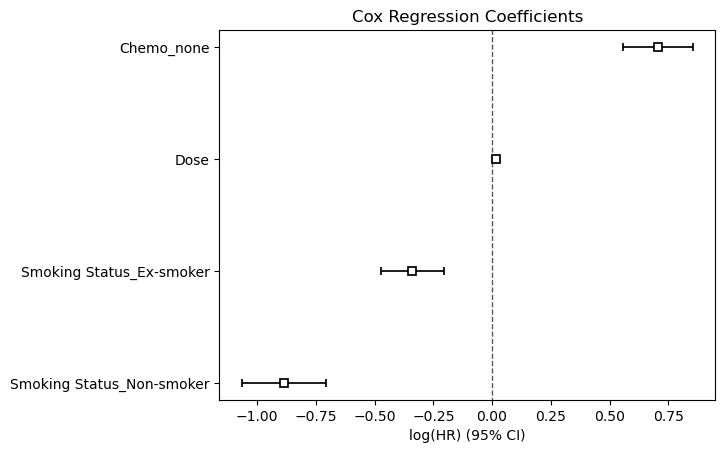


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3301 total observations, 2255 right-censored observations>
         test_name = proportional_hazard_test

---
                                test_statistic    p  -log2(p)
Chemo_none                km              2.46 0.12      3.10
                          rank            0.98 0.32      1.63
Dose                      km              5.82 0.02      5.98
                          rank            5.39 0.02      5.63
Smoking Status_Ex-smoker  km              0.84 0.36      1.48
                          rank            0.37 0.55      0.87
Smoking Status_Non-smoker km              2.07 0.15      2.74
                          rank            1.48 0.22      2.16



1. Variable 'Dose' failed the non-proportional test: p-value is 0.0158.

   Advice 1: the functional form of the variable 'Dose' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Dose' using pd.cut, and then specify it in `strata=['Dose',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumpti

[[<Axes: xlabel='rank-transformed time\n(p=0.0202)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0158)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3234)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1165)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5453)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3595)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2241)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1499)'>]]

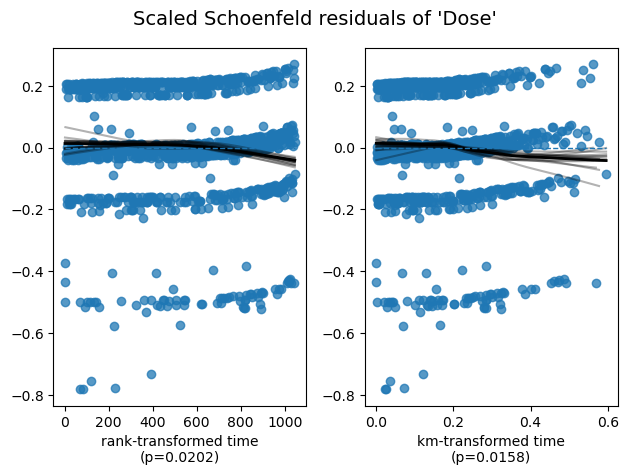

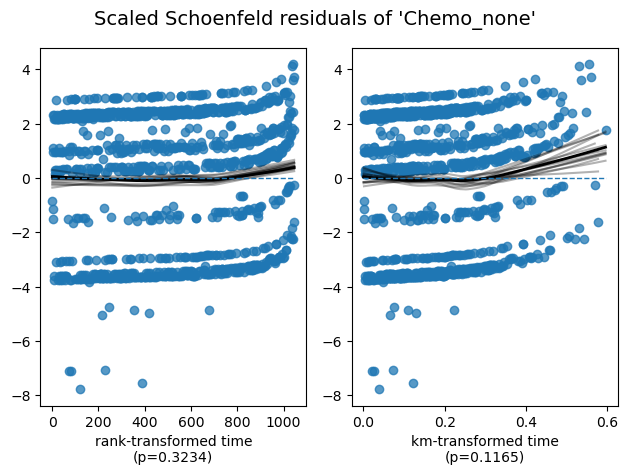

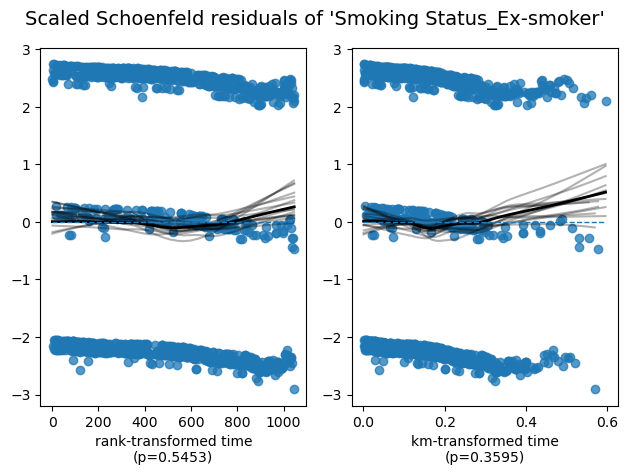

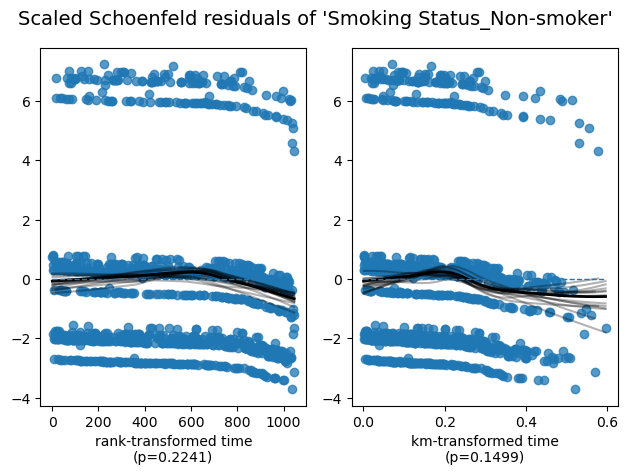

In [ ]:
from lifelines import CoxPHFitter # default non parametric

data = data1.copy()
# one hot encode 'Status'
data["Status"] = np.where(data["Status"]=="Dead", 1, 0)

# Fit the Cox proportional hazards model
# INSTANTIATE, FIT, PREDICT
cph = CoxPHFitter()
# tell the funx what col tells duration and what col is event 
# calculate time (in days but make it int64 type)
data['time'] = (data['Last FU'] - data['RT Start']).dt.days
print(data['time'].dtype)

# cph considers everything a covariate but needs them to be numeric, so tries to one-hot encode everything
# Only keep desired covariates (numeric) + time & event cols
covariates = ['time', 'Status', 'Chemo', 'Smoking Status', 'Dose']  # Add other numeric covariates you want
data_numeric = data[covariates]
data_numeric=data_numeric[data_numeric['Smoking Status'] != 'unknown'] # only NA category 
# one hot encode; *** drop_first=True *** means to drop the first 'dummy' col and use it as a reference for the other dummy columns
data_numeric = pd.get_dummies(data_numeric, drop_first=True)

cph.fit(data_numeric, duration_col='time', event_col='Status')
# within cph object, will have all the coefficients

# Print the summary of the model
cph.print_summary() # built in summary function 
# could also print specific variable outputs 

# Plot the coefficients
cph.plot()
plt.title('Cox Regression Coefficients')
plt.show()

# check assumptions
cph.check_assumptions(data_numeric, p_value_threshold=0.05, show_plots=True)

# 62% concordance 


https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
to validate PH assumptions 

### 3. Random Survival Forests (RSF)
- Build a Random Survival Forest model to predict survival.
- Perform variable importance analysis to identify the most predictive factors.
- Compare the model’s concordance index (C-index) with that of Cox regression

int64
['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'HPV', 'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status', 'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local', 'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca', 'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced', 'time']


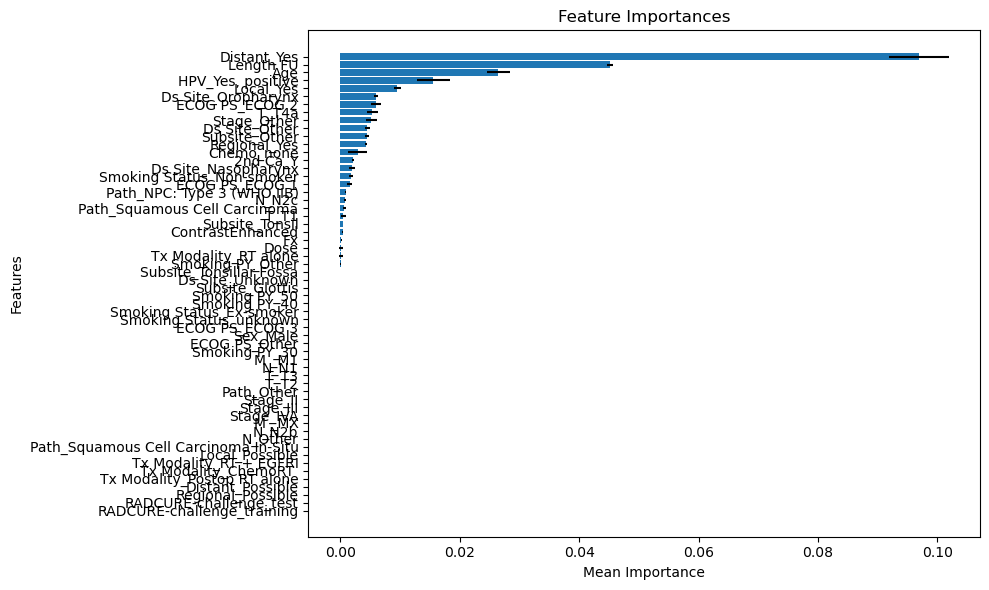

In [124]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
# this time using scikit for data prep, so y-variable will already be in compatable format (array)

# Load the dataset
data = data1.copy()
# one hot of event
data["Status"] = np.where(data["Status"]=="Dead", 1, 0)
# adjust time 
data['time'] = (data['Last FU'] - data['RT Start']).dt.days
print(data['time'].dtype)

cols = list(data.columns)
print(cols)
for name in cols:
    # if data[name].dtype == datetime64:  # didnt recognise the type ...
    #     data.drop(columns=name)
    if data[name].dtype == object:
        if name != 'time':
            if name != 'patient_id':
                if len(set(data[name]))>6:
                    top_values = data[name].value_counts().nlargest(4).index
                    # Replace all categories not in the top 5 with 'Other'
                    data[name] = data[name].where(data[name].isin(top_values), 'Other')


# set x and y; x = all features except event + time (but also remove all date cols)
data_x = data.drop(columns=['patient_id','Cause of Death', 'Status', 'time', 'RT Start', 'Last FU', 'Date of Death', 'Date Local', 'Date Regional', 'Date Distant', 'Date 2nd Ca'])

# for y, Convert to sksurv structured array format
data_y = Surv.from_dataframe(event='Status', time='time', data=data)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

# One hot encode categorical variables 
X_train = pd.get_dummies(X_train, drop_first=True)
# too many features require long processing time --> exmaine only top features 
top_features = X_train.columns[:80]
X_train_reduced = X_train[top_features]

# Train a Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=10, max_depth=3, random_state=42)
rsf.fit(X_train_reduced, y_train)

# please refer to https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html
# permutation importance: looking at differnet permutations and assessing importance in tree-based funcitonality; what features giving menaingful splits? what features show more importance?
# functionality for random forest classifier had this built in 
result = permutation_importance(rsf, X_train_reduced, y_train, n_repeats=3, random_state=42)
feature_importance = pd.DataFrame(
         {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_train_reduced.columns,
).sort_values(by="importances_mean", ascending=False)

# Sort by importances_mean and plot
feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# print(rsf.score(X_test, y_test)) #<-- to do 

In [129]:
# from sksurv.metrics import concordance_index_censored

X_test = pd.get_dummies(X_test, drop_first=True)
# since we selected top 80 featires for training data, must have same 80 features in testing data
# but first, must make sure the order of cols in tetsing data is the same as in training data, since it's taking the top 80
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_test_reduced = X_test[top_features]
c_index = rsf.score(X_test_reduced, y_test)
print(f"C-index (test): {c_index:.3f}")

C-index (test): 0.727
